# Ex08 Aplicações da DFT

## Parte 1 - Filtragem no Domínio da Frequência

Dos itens abaixo *a*, *b* e *c* você deve fazer obrigatoriamente o item *a* e no mínimo mais um item: *b* ou *c*. Nada impede você de fazer os 3 itens: *a*, *b* e *c*.

### a. Projetando filtros no domínio da frequência

Para projetar os filtros no domínio da frequência, utilize imagens sintéticas, como círculo ou quadrado ou retângulo (filtros ideais), tomando-se o cuidado para verificar se estes filtros são complexos-conjugados. Se preciso, crie uma função que retorne *True*, caso a imagem seja complexa conjugada e *False*, caso contrário. Lembre-se também que o projeto do filtro é normalmente feito no espectro ótico de Fourier, mas sua aplicação é feita com coordenadas 0 a N-1.

Teste os filtros projetados filtrando alguma imagem.

### b. Filtro Butterworth

Crie uma função para projetar um filtro passa-baixas Butterworth. A função de transferência do filtro passa-baixas de Butterworth de ordem $n$ e com posição da frequência de corte a uma distância $D_0$ da origem é definida pela relação $$ H(u,v) = \frac{1}{1 + [\frac{D(u,v)}{D_0}]^{2n}}, $$ onde $n$ é a ordem do filtro. Para facilitar a implementação, podemos usar a seguinte expressão: $$ H(u,v) = \frac{1}{1 + (\sqrt{2} - 1)(\sqrt{(\frac{u}{N})^2 + (\frac{v}{M})^2)}.t_c)^{2n}}$$ com $$ u \in{[-\frac{N}{2},N - \frac{N}{2} -1]}$$ $$ v \in{[-\frac{M}{2},M - \frac{M}{2} -1]}$$ $$ t_c \in{[2, max\{N,M\}]}$$

Compare o resultado da filtragem de uma imagem usando um filtro ideal e o filtro de Butterworth.

### c.  Filtrando uma imagem com textura

Veja que a imagem do código de barras a seguir possui uma textura no fundo. Projete um filtro (em frequencia) que elimine esta textura, sem borrar demais a imagem.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = mpimg.imread('../data/barcode.tif')
plt.figure(figsize=(8,8))
plt.imshow(f,cmap='gray');
plt.show()

## Parte 2 - Identificando Translação/Rotação por Correlação de Fase

Dos itens abaixo *a*, *b* e *c* você deve fazer obrigatoriamente o item *a* e no mínimo mais um item: *b* ou *c*. Nada impede você de fazer os 3 itens: *a*, *b* e *c*.

Através da Correlação de fase é possível identificar uma translação ou uma rotação sofrida por uma imagem (veja o notebook [Correlação de Fase](13 Correlacao de fase.ipynb)). 

### a. Coordenada polar da imagem ou da DFT?

Para identificar a rotação, a imagem é transformada para coordenadas polares, para depois ser aplicada a Transformada de Fourier e então calculada a correlação de fase. Verifique se é equivalente fazer a transformada de Fourier e só depois fazer a conversão para coordenadas polares no domínio da frequência para então computar a correlação de fase;

### b. Rotação e translação simultaneas

Imagine agora que uma imagem tenha sofrido rotação e translação simultaneamente. Tente agora identificar ambas transformações com esta mesma técnica. (DICA: Tente resolver o problema em 2 etapas, ou seja, aplicando 2 vezes os passos para a correlação de fase);
    c. (Opcional) Identifique o quão robusta é esta técnica, com relação a: ruído, variação de contraste, escala

### c. *Template Matching* 

Experimente resolver um problema de *Template Matching* usando correlação fase. Ou seja, recorte um pedaço de uma imagem e tente encontrar este pedaço na imagem original maior.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy.fft import *
import sys,os
from scipy import signal
from PIL import Image

ia898path = os.path.abspath('../../')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia

In [2]:
def circle(s, r, c): #s: dimensões fora da imagem, r: raio, c: centro da imagem
    rows, cols = s[0], s[1]
    rr0,  cc0  = c[0], c[1]
    rr, cc = np.meshgrid(range(rows), range(cols), indexing='ij')
    g = (rr - rr0)**2 + (cc - cc0)**2 <= r**2
    return g

def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

def view_fft2_ptrans(F):
    h,w = F.shape
    Ff = np.log(np.abs(ptrans2d(F, (h//2, w//2)))+1)
    return Ff

def view_fft2(F):
    F_v = np.log(np.abs(F)+1)
    return F_v

def myfft2(figure):
    h,w = figure.shape
    F = np.fft.fft2(figure)
    Ff = np.log(ptrans2d(F, (h//2, w//2))+1)
    return np.abs(Ff)

def ptrans2d(f,t):
    rr,cc = t
    H,W = f.shape
    
    r = rr%H
    c = cc%W
        
    g = np.empty_like(f)
    
    g[:r,:c] = f[H-r:H,W-c:W]
    g[:r,c:] = f[H-r:H,0:W-c]
    g[r:,:c] = f[0:H-r,W-c:W]
    g[r:,c:] = f[0:H-r,0:W-c]

    return g

## Parte 1

### Resolução exercício a:

In [3]:
image = Image.open('../data/cameraman.tif').convert('L')

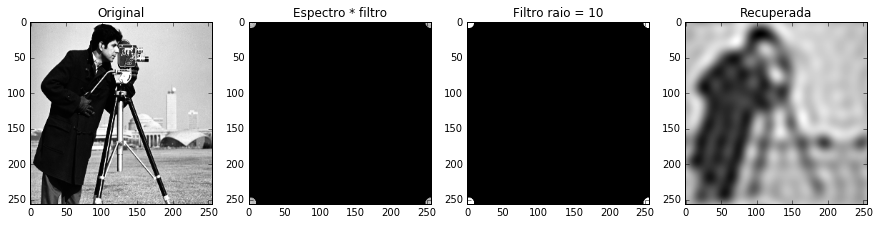

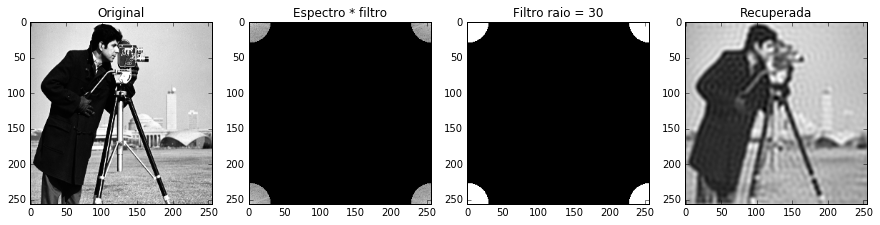

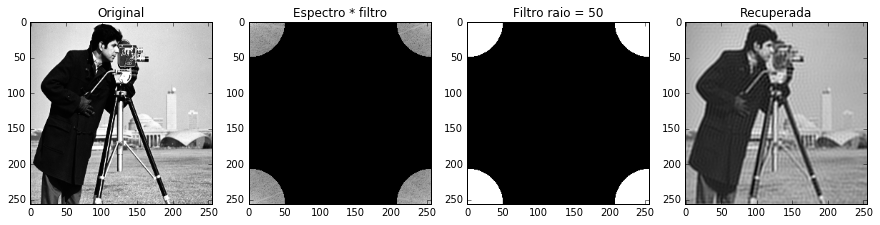

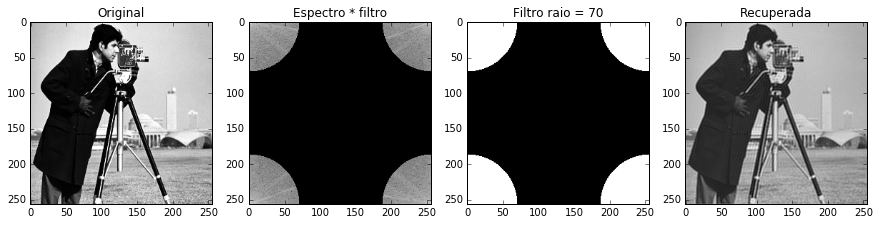

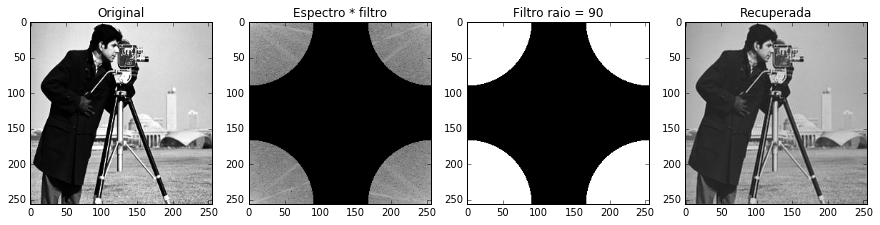

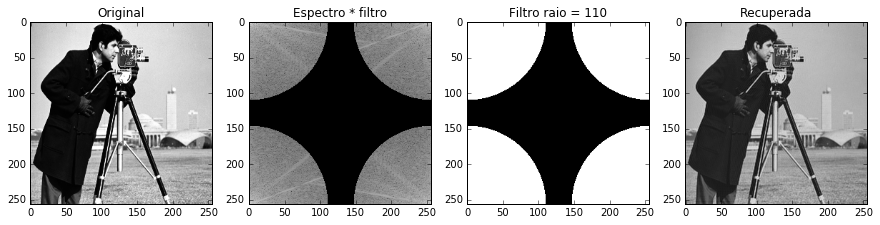

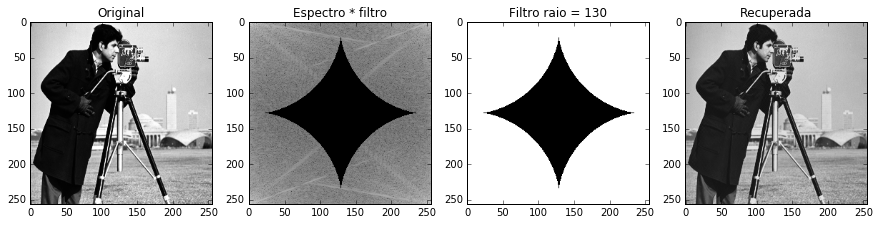

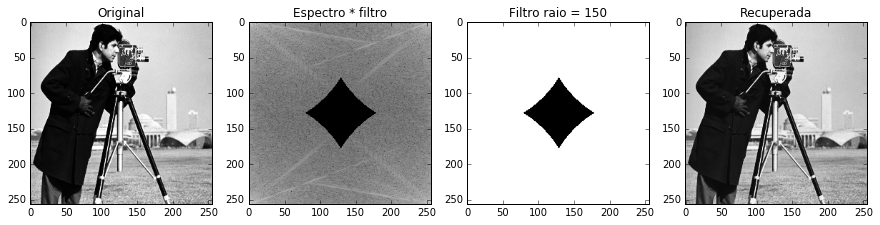

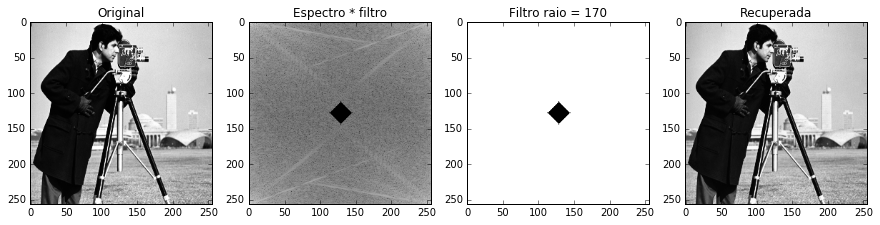

In [4]:
img = np.array(image)
IMG = fft2(img)

for i in range(10, 190, 20):
    r, c = img.shape
    w1 = circle([r, c], i , [0, 0])
    w2 = circle([r, c], i, [r, c])
    w3 = circle([r, c], i , [r, 0])
    w4 = circle([r, c], i, [0, c])
    w = w1+w2+w3+w4
    Iw = IMG * w
    iw = ifft2(Iw).real
    fig, ax = plt.subplots(1, 4, figsize=(15,15))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(np.log(np.abs(Iw)+1), cmap='gray')
    ax[2].imshow(w, cmap='gray')
    ax[3].imshow(normalize(iw), cmap='gray')
    ax[0].set_title('Original')
    ax[1].set_title('Espectro * filtro')
    ax[2].set_title(u'Filtro raio = %i' %i)
    ax[3].set_title(u'Recuperada')
    plt.show()

Podemos verificar nas imagens acima, que conforme aumenta o raio da circunferência, aumenta também a quantidade de frequências obtidas. Além disso, pode-se notar que a nossa percepção e muito sensível em baixas frequências e não percebemos com muita confiança a mudança dos raios para as altas frequências. É possível observar o aliasing nas imagens (raio=30 e 50), ou seja, linhas de contornos na imagem.

## Resolução exercício c:

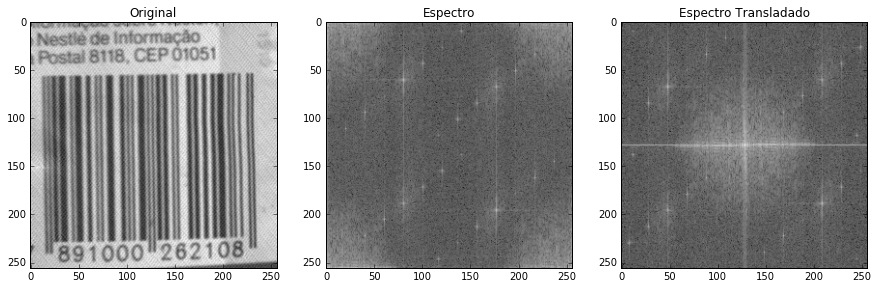

In [5]:
f = mpimg.imread('../data/barcode.tif')
#plt.figure(figsize=(8,8))

F = myfft2(f).real
F2 = fft2(f)
r, c = f.shape

fig2, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(f, cmap='gray')
ax[1].imshow(view_fft2(F2), cmap='gray')
ax[2].imshow(F, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Espectro')
ax[2].set_title('Espectro Transladado')
plt.show()

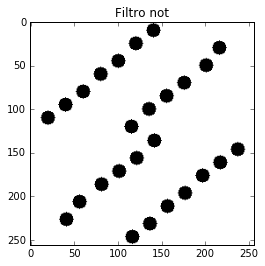

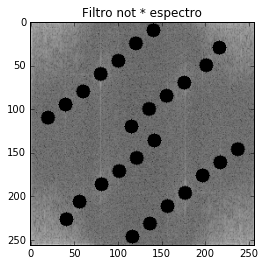

In [6]:
def ponto_circle(imagem, p):
    r,c = imagem.shape
    u, v = p
    m=np.ones((r,c))
    #m[u, v]=0
    uu = r-u
    vv = c-v
    k1 = circle([r,c], 8, [u,v])
    #m[-u, -v] = 1
    k2 = circle([r,c], 8, [uu,vv])
    m[k1] = 0
    m[k2] = 0
    return m

j1 = ponto_circle(F2, [110, 20])
j2 = ponto_circle(F2, [95, 40])
j3 = ponto_circle(F2, [80, 60])
j4 = ponto_circle(F2, [60, 80])
j5 = ponto_circle(F2, [45, 100])
j6 = ponto_circle(F2, [25, 120])
j7 = ponto_circle(F2, [10, 140])
j8 = ponto_circle(F2, [120, 115])

j9 = ponto_circle(F2, [100, 135])
j10 = ponto_circle(F2, [85, 155])
j11 = ponto_circle(F2, [70, 175])
j12 = ponto_circle(F2, [50, 200])
j13 = ponto_circle(F2, [30, 215])
j = ((j1+j2+j4+j3+j5+j6+j7+j8+j9+j10+j11+j12+j13)/13).astype('uint8')
#j = ((j1+j2+j4+j3+j5+j6+j7+j8)/8).astype('uint8')
k = ((j9+j10+j11+j12+j13)/5).astype('uint8')

F2j = F2*j
f2j = ifft2(F2j).real

#F2k = F2*k
#f2k = ifft2(F2k).real

#F2jk = F2j*k
#f2jk = ifft2(F2jk)

plt.imshow(j, cmap='gray')
plt.title('Filtro not')
plt.show()

plt.imshow(np.log(np.abs(F2j)+1), cmap='gray')
plt.title('Filtro not * espectro')
plt.show()

#print k[50, 200]

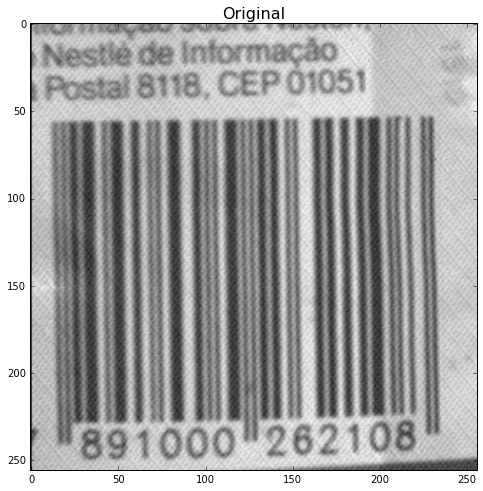

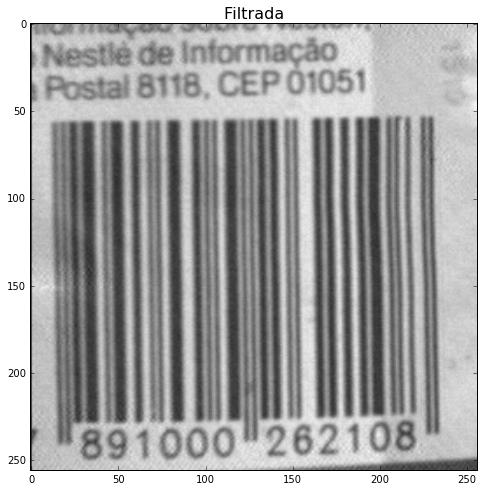

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(f, cmap='gray')
plt.title('Original', fontsize=16)
plt.show()
plt.figure(figsize=(8,8))
plt.title('Filtrada', fontsize=16)
plt.imshow(np.abs(f2j), cmap='gray')
plt.show()

Quando a transformada de fourier da imagem é obtida, pode-notar que existem alguns pontos, os quais representam senoídes de diferentes frequências e ângulos. Essas senóides representam o efeito de texturas na imagem. Para retirar esse efeito foi utilizado um filtro not correspondente a cada ponto real e conjugado do espectro. Podemos observar a imagem filtrada acima que reduzimos drasticamente o efeito de textura na imagem.

## Parte 2

## Resolução exercício a:

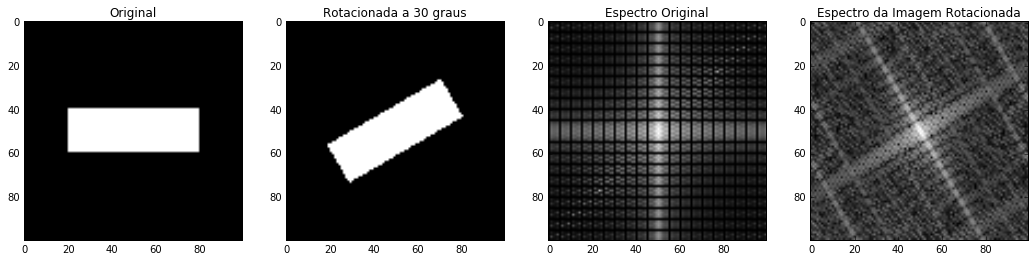

In [8]:
#Imagem sintética
z = np.zeros((100, 100))
z[40:60:, 20:80]=1

#Imagem Real
#z = Image.open('../data/cavalo.jpg').convert('L')
#z = np.array(z)

def rot_borda(f, ang):
    # Inserindo uma borda de zeros para permitir a rotação da imagem
    t = np.zeros(np.array(f.shape)+100,dtype=np.uint8)
    t[50:f.shape[0]+50,50:f.shape[1]+50] = f
    f = t

    t1 = np.array([
                 [1,0,-f.shape[0]/2.],
                 [0,1,-f.shape[1]/2.],
                 [0,0,1]]);

    t2 = np.array([
                 [1,0,f.shape[0]/2.],
                 [0,1,f.shape[1]/2.],
                 [0,0,1]]);

    # Rotacionando a imagem 30 graus
    theta = np.radians(ang)
    r1 = np.array([
            [np.cos(theta),-np.sin(theta),0],
            [np.sin(theta),np.cos(theta),0],
            [0,0,1]]);

    T = t2.dot(r1).dot(t1)
    f_rot = ia.affine(f,T,0)
    return f_rot

z_rot = rot_borda(z, 30)
#z_rot = z_rot[50:150, 50:150]
z_rot = z_rot[50:z_rot.shape[0]-50,50:z_rot.shape[1]-50]

Z = myfft2(z)
Z_rot = myfft2(z_rot)

fig3, ax = plt.subplots(1, 4, figsize=(18, 18))
ax[0].imshow(z, cmap='gray')
ax[1].imshow(z_rot, cmap='gray')
ax[2].imshow(Z, cmap='gray')
ax[3].imshow(Z_rot, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Rotacionada a 30 graus')
ax[2].set_title('Espectro Original')
ax[3].set_title('Espectro da Imagem Rotacionada')

#### 1. Processo: polar > fft > correlação de fase

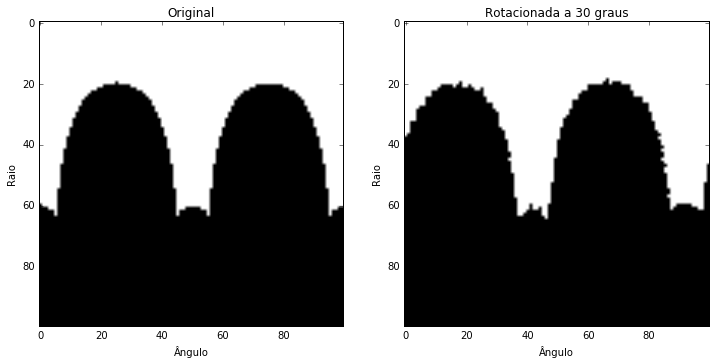

In [9]:
z_p = ia.polar(z, z.shape, 2*np.pi)
z_rot_p = ia.polar(z_rot, z_rot.shape, 2*np.pi)

fig4, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(z_p, cmap='gray')
ax[1].imshow(z_rot_p, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Rotacionada a 30 graus')
ax[0].set_xlabel(u'Ângulo')
ax[0].set_ylabel('Raio')
ax[1].set_xlabel(u'Ângulo')
ax[1].set_ylabel('Raio')
plt.show()

In [10]:
corr_z = ia.phasecorr(z_p, z_rot_p)

# Encontrando o ponto de máxima correlação 
i = np.argmax(corr_z)
c = np.unravel_index(i,corr_z.shape)

# Calculate the angle
angulo = (float(c[1])/corr_z.shape[1])*360
print'Ponto de máxima correlação fazendo o 1. Processo: ',angulo

Ponto de máxima correlação fazendo o 1. Processo:  28.8


#### 2. Processo: fft > polar > correlação de fase

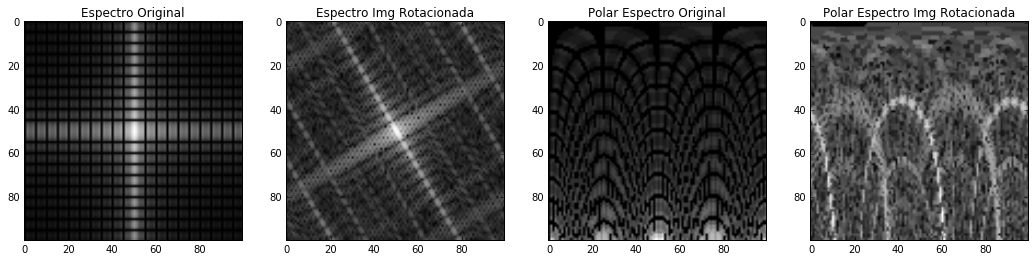

In [15]:
Z2 = fft2(z)
Z_rot2 = fft2(z_rot)

Z2_p = ia.polar(Z2, Z2.shape, 2*np.pi)
Z_rot2_p = ia.polar(Z_rot2, Z_rot2.shape, 2*np.pi)

fig5, ax = plt.subplots(1, 4, figsize=(18, 18))
ax[0].imshow(view_fft2_ptrans(Z2), cmap='gray')
ax[1].imshow(view_fft2_ptrans(Z_rot2), cmap='gray')
ax[2].imshow(normalize(view_fft2(Z2_p)), cmap='gray')
ax[3].imshow(normalize(view_fft2(Z_rot2_p)), cmap='gray')
ax[0].set_title('Espectro Original')
ax[1].set_title('Espectro Img Rotacionada')
ax[2].set_title('Polar Espectro Original')
ax[3].set_title('Polar Espectro Img Rotacionada')
plt.show()

In [16]:
def phasecorr_sem_fft(F,H):
    #F = np.fft.fftn(f)
    #H = np.fft.fftn(h)
    T = F * np.conjugate(H)
    R = T/np.abs(T)
    g = np.fft.ifftn(R)
    return g.real

corr_z2 = phasecorr_sem_fft(Z2_p, Z_rot2_p)

# Encontrando o ponto de máxima correlação 
i2 = np.argmax(corr_z2)
c2 = np.unravel_index(i2,corr_z2.shape)

# Calculate the angle
angulo2 = (float(c2[1])/corr_z2.shape[1])*360
print'Ponto de máxima correlação fazendo o 2. Processo: ',angulo2

Ponto de máxima correlação fazendo o 2. Processo:  0.0


C:\Users\Fernanda\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in divide


Podemos notar que no primeiro processo conseguimos encontrar a correlação da imagem rotacionada, ou seja, o valor do ângulo encontrado estava próximo ao valor do ângulo utilizado para rotacionar a imagem. Entretando, o segundo processo mostrou que não é possível, pois não existe correlção entre os espectros.  

## Resolução exercício b:

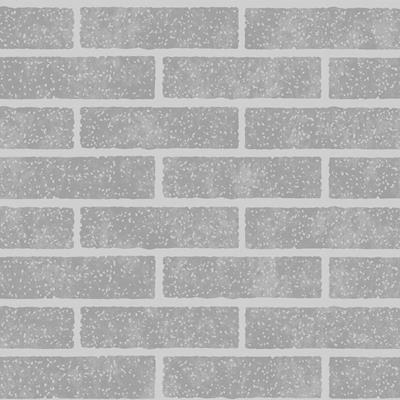

In [24]:
tijolo = Image.open('../data/tijolo.jpg').convert('L')
tij = np.array(tijolo)
tijolo

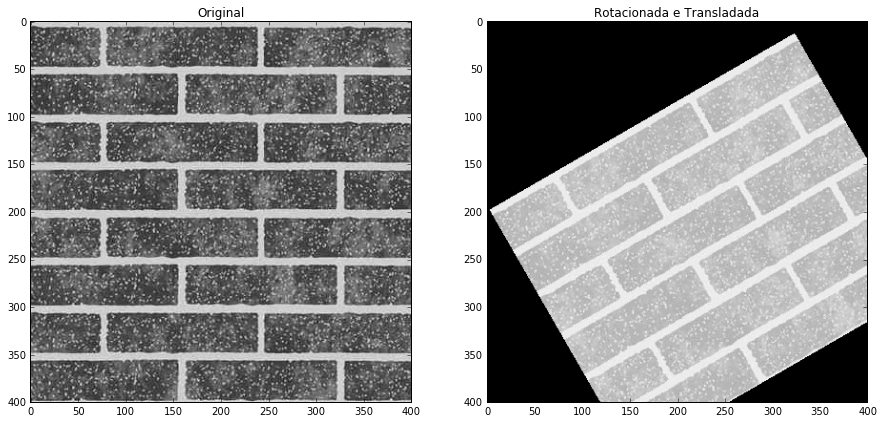

In [23]:
# Translação da imagem
x = 100
y = 30
tij_trans = np.zeros(tij.shape)
tij_trans[x:, y:] = tij[:-x, :-y]

# Rotação da imagem

tij_trans_rot = rot_borda(tij_trans, 30)
tij_trans_rot = tij_trans_rot[50:tij_trans_rot.shape[0]-50,50:tij_trans_rot.shape[1]-50]


fig5, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(normalize(tij), cmap='gray')
ax[1].imshow(normalize(tij_trans_rot), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Rotacionada e Transladada')
plt.show()

In [25]:
# Calculando a correlação de fase

corr_tij_trans = ia.phasecorr(tij, tij_trans_rot)

# Encontrando o ponto de máxima correlação 
i_b = np.argmax(corr_tij_trans)
row,col = np.unravel_index(i_b,corr_tij_trans.shape)
v = np.array(corr_tij_trans.shape) - np.array((row,col))
print'Ponto de máxima correlação: ',v

Ponto de máxima correlação:  [ 85 122]


Podemos verificar que o ponto translada está incorreto. Por isso, vamos rotacionar e verificar o ângulo encontrado.

In [26]:
tij_p = ia.polar(tij, tij.shape, 2*np.pi)
tij_trans_rot_p = ia.polar(tij_trans_rot, tij_trans_rot.shape, 2*np.pi)

corr_tij = ia.phasecorr(tij_p, tij_trans_rot_p )

# Encontrando o ponto de máxima correlação 
i_b2 = np.argmax(corr_tij)
c_b2 = np.unravel_index(i_b2,corr_tij.shape)

# Calculate the angle
angulo_b = (float(c_b2[1])/corr_tij.shape[1])*360
print'Ponto de máxima correlação: ', angulo_b

Ponto de máxima correlação:  29.7


O valor da correlação de fase está próximo ao valor real. Para encontrar a translação da imagem, vamos retornar a imagem na rotação inicial.

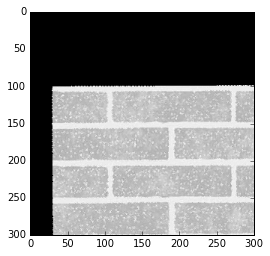

In [28]:
# Desrotacionando a imagen de acordo com o ângulo encontrado
tij_rot2 = rot_borda(tij_trans_rot, -angulo_b)
tij_rot2 = tij_rot2[50:tij_trans_rot.shape[0]-50,50:tij_trans_rot.shape[1]-50]

plt.imshow(tij_rot2, cmap='gray')
plt.show()

In [29]:
# Calculando a correlação de fase

corr_tij_rot2 = ia.phasecorr(tij[0:300, 0:300], tij_rot2)

# Encontrando o ponto de máxima correlação 
i_b2 = np.argmax(corr_tij_rot2)
row2,col2 = np.unravel_index(i_b2,corr_tij_rot2.shape)
v2 = np.array(corr_tij_rot2.shape) - np.array((row2,col2))
print'Ponto de máxima correlação: ',v2

Ponto de máxima correlação:  [100  30]


Podemos concluir, que foi obtido o ângulo de correlação, rotacionada a imagem para o ângulo inicial e por fim encontrada a correlação de tranlação da imagem.